Zachary Rowland

# CPS 491 Main Jupyter Notebook

Contents

- [Python Imports](#Python-Imports) Python imports for the whole document
- [Introduction](#Introduction) Project motivation
- [Discovering Functions using SINDy](#Discovering-Functions-Using-SINDy) Introduction to SINDy and model fitting using regression
- [Applying SINDy to MNIST](#Applying-SINDy-to-MNIST) Experimenting with finding concise equations for image classification.
- [Maclaurin Series Approximations](#Maclaurin-Series-Approximations) Older work experimenting with Maclaurin approximations.
- [Change-of-Basis Approximation Strategy](#Change-of-Basis-Approximation-Strategy) A general approximation technique using one hidden layer and an arbitrary activation function.
- [Approximating an Arbitrary Function using Convolution](#Approximating-an-Arbitrary-Function-using-Convolution) A method for approximating an arbitrary function inspired by convolution.
- [Helpful Mathematical Theory](#Helpful-Mathematical-Theory) Math that might be related to the direction of the project.
- [Related Work](#Related-Work) A small literature review of model compression and approximation theory of neural networks.

[Tensorflow Guide](https://www.tensorflow.org/guide/)


# Python Imports

These are just global imports that are used by the whole document. Run the following cell before running anything else.

In [3]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz as gv
import sklearn.linear_model
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from IPython.display import display, Math, Latex

# Introduction

Learning systems have always been an important part of data analysis. The simplest method of learning a function from data is the linear regression, but today's deep neural networks have proven capable of learning a variety of non-linear functions. However, deep neural networks are still shrowded in an air of mystery because of their complexity. Deep neural networks commonly have thousands of parameters that describe the precise function that the network implements as opposed to the two parameters learned by a simple linear regression. The main benefit of increasing the number of parameters is increasing expressivity, the amount and types of functions that can be learned. But the downside of expressive learning systems is intractable resulting models.

Many researchers interested in applying deep learning consider trading tractability for expressivity to be an acceptable trade-off. However, [Lin et. al.](https://arxiv.org/pdf/1608.08225.pdf) questions if this exchange is necessary. Most phenomena in the natural sciences can be described with low-complexity mathematical models built from a combination of a small number of simple "base functions" such as polynomials, sinusoids, and exponentials. This insight suggests that neural networks are probably much more complex than is necessary to express the functions they are learning. Large sections of a trained network might be performing meaningless computations, or performing useful computations that could be computed with less machinary.

The inscrutible nature of DNNs motivates research into smaller learning systems that that are more tractable.

1. **Model compression** attempts to reduce the complexity of a trained DNN by pruning pieces off of the network that are deemed unnecessary.
2. **Alternative learning systems** such as fuzzy inference systems attempt to make the function-approximation framework itself intuitive to humans.



# Searching for an Analytical Model Compression Scheme

Part of the reason neural networks are hard to understand is that their mathematical representation is dissimilar to any other mathematical models we usually come across. To illustrate, consider the following function that represents some trained neural network with three hidden nodes using the standard sigmoid activation function $\sigma(x) = (1+e^{-x})^{-1}$.

$$ f(x) = 1.98\sigma(2.32x - 0.27) + 2.18\sigma(-2.20x + 6.91) + 1.81\sigma(2.37x -14.45) - 3.07 $$

This function turns out to be a very good approximation of $\sin(x)$ for $x \in [0, 2\pi]$. However, the only way we know that is from a crude analysis of the outputs such as a root-mean-square comparison.
A good question is whether or not there is some theory that formalizes, and makes intuitive, the connection between the parameters and structure of $f$ and the more commonly used sine function.

To illustrate the challenge, consider the set of polynomial functions $\mathbb{R} \rightarrow \mathbb{R}$ of the form $p(x) = \theta_0 + \theta_1 x + \theta_2 x^2 \cdots + \theta_d x^d$. Given data $(x_0, y_0)...(x_n, y_n)$, a unique $n$-degree polynomial that precisely models this data can be found by solving a simple linear system (assuming the $x_i$ values are all different).

$$ \pmb{0} = X\pmb{\theta} - \pmb{y} $$
$$ \begin{bmatrix} 0 \\ 0 \\ \vdots \end{bmatrix} = \begin{bmatrix} 1 & x_0 & x_0^2 & \\ 1 & x_1 & x_1^2 & \cdots \\ & \vdots \end{bmatrix} \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \end{bmatrix} - \begin{bmatrix} y_0 \\ y_1 \\ \vdots \end{bmatrix}  $$

Lower-degree, best-fit polynomials can be found through a similar method called regression. For degrees less than $n$, the $X$ matrix becomes non-square and the system above will probably be unsolvable. So instead, the goal is to minimize the distance between $X\pmb{\theta} - \pmb{y}$ and the zero vector:
$$ \pmb{\theta} = \min_{\theta} || X\theta - \pmb{y} ||^2 $$
This problem can be viewed as finding the point on an embedded hyperplane that is closest to the origin. This means that the parameters $\pmb{\theta}$ are unique, and an method for finding these parameters such as gradient descent should always converge to this unique answer. Furthermore, there is established theory on finding polynomial approximations for other common functions such as Taylor expansions.

Neural networks, on the otherhand, do not have these nice properties. Given a neural network $f(x;\theta)$ trained to learn some true function $g(x)$:

1. The parameters $\theta$ are not necessarily unique. Different sets of parameters could give two different globally optimal functions (or the same optimal function expressed with different parameter sets).
2. The parameters $\theta$ learned from an iterative process such as gradient descent are not guarenteed to be not globally optimal, only _locally optimal_ as determined by the values to which $\theta$ was initialized.

One way we could start is by defining a mechanized scheme for how a neural network _could_ approximate a given function, but not necessarily how the network _will_ approximate that function after training. For example, Lin points out that the operation of multipliying two real numbers $\mathbb{R}^2 \rightarrow \mathbb{R}$ can be approximated to arbitrary accuracy with a 3-layer network with 4 hidden nodes:

$$ \text{mult}(x_1, x_2) = \lim_{h \rightarrow 0} \frac{\sigma(ha) + \sigma(-ha) - \sigma(hb) - \sigma(-hb)}{4 h^2 \sigma''(0)} $$

$$ \text{where}\ \ a = x_1 + x_2 \qquad b = x_1 - x_2 $$

This approximation is independent of the activation function $\sigma$ used, only requiring $\sigma''(0) \ne 0$. This multiplication operation can be used to construct neural networks that approximate any polynomial. The only additional component needed is a way to propogate values unchanged from one layer to the next, in other words, an approximation of the identity function:

$$ \text{id}(x) = x = \lim_{h \rightarrow 0} \frac{\sigma(hx) - a(0)}{h \sigma'(0)} $$

These two components, along with the native addition operation, can be used to define neural networks that approximate any multivariate polynomial. Furthermore, Taylor's theorem provides a way of constructing polynomials that approximate any differentiable curve on some domain. Consequently, given a function $g$, we can generate sequences of neural networks that approach $g$ by changing $h$ or by approximating more terms in the Taylor expansion of $g$.


Theoretically, a tool could be built that searches for these Taylor constructions in trained neural networks and identifies the original function being approximated. However, building such a tool might not be practical or desirable for a number of reasons.

First, there are many ways of combining $\text{mult}$ and $\text{id}$ to approximate a particular polynomial. For example, different compositions of multiplication often yield the same power of $x$ e.g. $\text{mult}(\text{mult}(x, x), \text{mult}(x, x)) = \text{mult}(x, \text{mult}(x, \text{mult}(x, x)))$. This means that the set of network configurations we are searching for is large and hard to describe.

Second, requiring $h$ to approach zero leads to neural networks with very large and small parameters, especially as powers of $h$ become involved. In practice, neural networks are initialized randomly with numbers roughly in the single digits, and the training rate will probably be too small to push these parameters high enough while simultaneously being too large to make subtle changes to parameters close to zero. In essence, real networks will almost certainly never learn parameters like this.

To summarize, any theory behind neural networks would have to keep in mind how neural networks are actually constructed and how they learn: they are constructed using sigmoid-like activation functions and learn using an iterative refinement process that finds a local best approximation based on a root-mean-square error calculation.

# Data-Driven Approach

The difficulties of understanding DNNs analytically motivate a more data-driven approach of model compression. A data-driven approach ignores the structure of a neural network entirely and only uses the network to generate data. The data generated by the machine is then fitted with a mathematical model. For regression problems, a data-driven system that learns mathematical equations has potential to replace the neural network altogether. Alternatively, if the trained neural network is not fully connected, the network could be collapsed into equations section-by-section, and the learned equations could then be composed to represent the whole network.

# Discovering Functions Using SINDy

Paper: \\
Brunton, Steven L., et. al. "Sparse Identification of Nonlinear Dynamics with Control (SINDYc)." 2016. https://arxiv.org/abs/1605.06682.

SINDy is a method for fitting functions to time data using linear regression. SINDy finds a best fit function of the form $f(x) = w_0 f_0(x) + w_1 f_1(x) + \cdots + w_n f_n(x) + b$ for time data $(x_t, y_t)$. More precisely, it finds the coefficients $w_i$ and $b$ that optimize the approximation:

$$ \begin{bmatrix} y_0 \\ y_1 \\ \vdots \end{bmatrix} \approx \begin{bmatrix} f_0(x_0) & f_1(x_0) \\ f_0(x_1) & f_1(x_1) & \cdots \\ \vdots & \vdots \end{bmatrix} \begin{bmatrix} w_0 \\ w_1 \\ \vdots \end{bmatrix} + b \begin{bmatrix} 1 \\ 1 \\ \vdots \end{bmatrix}$$

The approximation above is specifically for functions $f: \mathbb{R} \rightarrow \mathbb{R}$, but it generalizes to data of arbitrary dimensions.

We could use SINDy to fit functions based on input/output data from a trained neural network. The main two questions are:
1. What is the best way to gather data from a trained neural network?
2. What sets of functions $f_i$ can we use to give us useful information? The $f_i$ functions should be independent of each other otherwise there would be infinite best-fit models.

## Fitting Polynomials

An obvious choice of library functions is powers of the input ($x$, $x^2$, ...) which would give us polynomial models. We could then compare the resulting polynomial model with known polynomial approximations for common functions (e.g. Maclaurin series).

Model: + 0.99x^0 + -0.98x^1 + 0.52x^2 + -0.18x^3 + 0.09x^4 + 0.00x^5


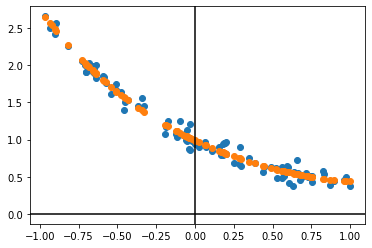

In [ ]:
# Construct data
f = lambda x: np.exp(-x)
xdata = np.random.uniform(low=-1.0, high=1.0, size=[100])
ydata = f(xdata) + np.random.normal(scale=0.08, size=[100])

# Fit a fifth-degree polynomial with regression
X = np.column_stack([xdata, xdata**2.0, xdata**3.0, xdata**4.0, xdata**5.0])
reg = sklearn.linear_model.LinearRegression()
reg.fit(X, ydata)

# Print model
print("Model:", end="")
for c, b in zip([reg.intercept_]+list(reg.coef_), range(6)):
  print(f" + {c:.2f}x^{b}", end="")
print()

# Plot data and model predictions
plt.axhline(color="black"); plt.axvline(color="black")
plt.scatter(xdata, ydata)
plt.scatter(xdata, reg.predict(X))
plt.show()

## Fitting Sinusoids

Another obvious choice of library functions is sinusoids.

For example, suppose we know that the data is approximately sinusoidal with angular frequency $\omega$, then we could find a model of the form
$$ r\sin(\omega x + \psi) + b $$
by using the library $\{\sin(\omega x), \cos(\omega x)\}$:

$$ r \sin(\omega x + \psi) + b = w_0\sin(\omega x) + w_1\cos(\omega x) + b $$

We would just need to convert the cartesian coordinates $w_0, w_1$ into polar coordinates $r,\psi$:

$$ r = \sqrt{w_0^2 + w_1^2} \qquad \psi = \begin{cases} \cos^{-1}(w_0/r) & w_1 \ge 0 \\ 2\pi - \cos^{-1}(w_0/r) & w_1 < 0 \end{cases} $$

Model: 0.37sin(x) + 0.35cos(x) + 0.21
Model: 0.51sin(x + 0.76) + 0.21
Model R^2 value: 0.98


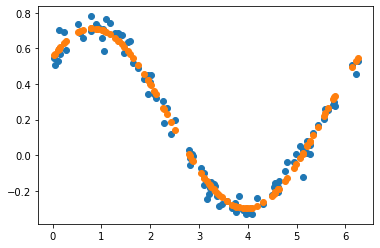

In [ ]:
# Construct data
f = lambda x: 0.5*tf.sin(x + 0.79) + 0.2
xdata = tf.random.uniform([100], minval=0.0, maxval=math.pi * 2.0)
ydata = f(xdata) + tf.random.normal([100], stddev=0.05)

# (x,y) -> (r,theta)
def cart2polar(x, y):
  r = math.sqrt(x**2.0 + y**2.0)
  theta = math.acos(x/r) if y >= 0.0 else 2*math.pi - math.acos(x/r)
  return [r,theta]

# Fit regression against our basis {sin(x), cos(x)}
# to get w0, w1, b
X = np.column_stack([tf.sin(xdata), tf.cos(xdata)])
reg = sklearn.linear_model.LinearRegression()
reg.fit(X, ydata)
w0, w1 = reg.coef_
b = reg.intercept_

# Output model equation in two different forms
# Plot data and model predictions
print(f"Model: {w0:.2f}sin(x) + {w1:.2f}cos(x) + {b:.2f}")
r, theta = cart2polar(w0, w1)
print(f"Model: {r:.2f}sin(x + {theta:.2f}) + {b:.2f}")
print(f"Model R^2 value: {reg.score(X, ydata):.2f}")
print(plt.scatter(xdata, ydata))
print(plt.scatter(xdata, reg.predict(X)))

Alternatively, suppose we know our data is sinusoidal, but don't know the angular frequency $\omega$:

$$ f(x) = \sin(\omega x) $$

To find the angular frequency, we could use Fourier analysis. The Fourier transform of a pure sine wave will be zero everywhere except for at the frequency of the wave:

$$ \hat{f}(\xi) = \int_{-\infty}^{\infty} f(t)\cos(2\pi\xi t)\ dt - i\int_{-\infty}^{\infty} f(t)\sin(2\pi\xi t)\ dt $$

We are not interested in calculating values of the Fourier transform, but only in discovering frequencies where $\hat{f}$ is large. This means we can integrate on a finite interval instead of over all real numbers:

$$ g(\xi) = \int_{0}^{L} f(t)\cos(2\pi\xi t)\ dt - i\int_{0}^{L} f(t)\sin(2\pi\xi t)\ dt $$

The function $g$ converges to $\hat{f}$ as the range of the integration increases. But importantly, even if the range is small, the value of $n$ that maximizes $g$ should be approximately the same $n$ value that maximizes $\hat{f}$.

$$ \max_{\xi}|g(\xi)| \approx \max_{\xi}|\hat{f}(\xi)| $$

Now we have the correspondence:

$$ g\left( \frac{n}{L} \right) = \frac{L}{2} (a_n - ib_n) $$

where $a_n$ and $b_n$ are the coefficients of the Fourier series expansion of $f$:

$$ f(x) = a_0 + \sum_{n=1}^{\infty} \left[ a_n\cos\left(\frac{2\pi nx}{L}\right) + b_n\sin\left(\frac{2\pi nx}{L}\right) \right] $$

$$ a_n = \frac{2}{L}\int_0^{L} f(x)\cos\left( \frac{2\pi nx}{L} \right)\ dx $$
$$ b_n = \frac{2}{L}\int_0^{L} f(x)\sin\left( \frac{2\pi nx}{L} \right)\ dx $$

So, we want to find

$$ \max_{\xi} \left| g\left(\xi\right)\right| = \frac{L}{2}(a_{L\xi}^2 + b_{L\xi}^2) $$


Closest frequency: 2.0


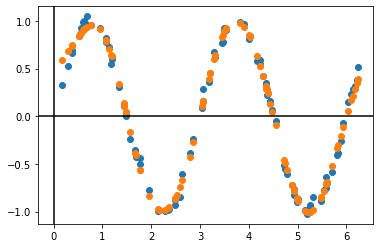

In [ ]:
# TODO: complete this demo
# Construct data
f = lambda x: np.sin(2.1*x)
xdata = tf.random.uniform([100], minval=0.0, maxval=math.pi * 2.0)
ydata = f(xdata) + tf.random.normal([100], stddev=0.05)

# Fit a regression using a basis of sinusoids
X = np.column_stack([np.sin(n*0.5*xdata) for n in range(1,11)]\
                  + [np.cos(n*0.5*xdata) for n in range(1, 11)])
reg = sklearn.linear_model.LinearRegression()
reg.fit(X, ydata)

# Find largest coefficient
i_of_largest_coef = np.argmax(reg.coef_)
print("Closest frequency:", 0.5*(i_of_largest_coef+1))

# Estimate the frequency


# Plot data and model predictions
plt.axhline(color="black"); plt.axvline(color="black")
plt.scatter(xdata, ydata)
plt.scatter(xdata, reg.predict(X))
plt.show()

## Multivariable Inputs

So far, I have only really considered neural networks that learn a function $f: \mathbb{R}\rightarrow \mathbb{R}$. However, a network trained on the MNIST dataset is a function $f: \mathbb{R}^{784} \rightarrow \mathbb{R}^{10}$. What are the consequences of this increased dimensionality?

Well, increasing the output dimensionality shouldn't be too difficult to handle because we can just consider each output individually. For MNIST, we could start by just examining the first output that detects the digit '0'.

Large input dimensions may be a little more challenging. If the goal is to find a mathematical representation of $f$ that is more concise than the neural network itself, then there is little point in finding a function $f$ that is dependent on all 784 input variables (not to mention the combinations of those input variables). We need a way of systematically eliminating terms that are unimportant. Can we define a process such as the following:

* repeat:
  1. Fit data against a set of basis functions $B$
  2. Eliminate unimportant basis functions
  3. Identify new basis functions that may be significant and add them to $B$.

The third step is the most difficult. To start, we could just naively consider every basis function to be possibly significant. We could start with $B = \{x_1, x_2, ..., x_{784}\}$ and find a linear fit, eliminate terms with small coefficients, then add $\{x_1^2, x_1 x_2, x_1 x_3, ..., x_1 x_{784}\}$, and so on. However, it would be nice to have a way of determining which basis functions are most likely to be significant by using the model from the previous iteration.

**Idea 1**: _the functions in $B$ should only be compositions of basis functions from the $B$ of the previous iteration._

For example, we could start by fitting a linear regression against $B=\{x_1, x_2, x_3, x_4\}$. Suppose we find out that the coefficients on $x_3$ and $x_4$ are negligible. Then our next set of basis functions could be $B = \{x_1, x_2, x_1^2, x_2^2, x_1 x_2\}$ only constructed from the previously significant functions. The problem is that if the coefficient on $x_3$ is close to zero, that doesn't mean $x_3$ is unimportant, it just means that _on average_, the output doesn't change with respect to $x_3$.

**Idea 2**: _find ways of representing compound functions using sums of other functions_

For example, a function of the form $a\cos(x) + b\sin(x)$ can always be rewritten in the form $r\sin(x + \psi)$ via a simple cartesian->polar coordinate conversion. Fourier series and Taylor series are also techniques for doing this, but prevent their own challenges:
* While there are algorithms to convert functions into polynomials, sinusoids, etc (Maclaurin series, Fourier analysis), there are not general algorithms to convert back to the original functions.

# Applying SINDy to MNIST

In [4]:
# Function definitions for this section

def constructModel():
  """Builds a 4-layer neural network, trains it on MNIST data,
  prints information, saves the model to a file, returns model"""
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  x_train = x_train.reshape(60000, 784).astype("float32") / 255
  x_test = x_test.reshape(10000, 784).astype("float32") / 255

  # Build and compile model
  inputs = keras.Input(shape=(784,))
  hiddl1 = keras.layers.Dense(183, activation="relu")(inputs)
  hiddl2 = keras.layers.Dense(57, activation="relu")(hiddl1)
  outputs = keras.layers.Dense(10, activation="relu")(hiddl2)
  model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
  model.summary()
  model.compile(
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=keras.optimizers.RMSprop(),
      metrics=["accuracy"],
  )

  # Fit data, print test results
  model.fit(x_train, y_train, batch_size=64, epochs=3, validation_split=0.2)
  test_scores = model.evaluate(x_test, y_test, verbose=2)
  print("Test loss:", test_scores[0])
  print("Test accuracy:", test_scores[1])
  model.save("mnist_model.h5")
  print("Saved model to mnist_model.h5")
  return model

def getDataForDigit(digit, model=None):
  """
  Returns (x_data, y_data)
  x_data: numpy array (10000, 784)
  y_data: numpy array (10000,)
  If model is `None` then it is loaded from file
  """
  _, (x_data, _) = keras.datasets.mnist.load_data()
  x_data = x_data.reshape(10000, 784).astype("float32") / 255
  if not model:
    model = keras.models.load_model("mnist_model.h5")
  y_data = model.predict(x_data)
  y_data = np.array([y[digit] for y in y_data])
  return x_data, y_data

def linearRegression(X, y_data):
  """Returns the regression object that results from
  fitting the given data"""
  reg = sklearn.linear_model.LinearRegression()
  reg.fit(X, y_data)
  return reg

def showAsImages(pixeldatalist, titles=None):
  """
  Displays `len(pixeldatalist)` images, each 28x28 pixels
  """
  pixeldatalist = [np.array(item) for item in pixeldatalist]
  f, axes = plt.subplots(1, len(pixeldatalist))
  for i, axis in enumerate(axes):
    axis.imshow(pixeldatalist[i].reshape(28, 28), cmap="gray")
    if titles:
      axis.set_title(titles[i])
  f.set_size_inches(8, 8)
  plt.show()

In [7]:
constructModel()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 183)               143655    
_________________________________________________________________
dense_4 (Dense)              (None, 57)                10488     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                580       
Total params: 154,723
Trainable params: 154,723
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
750/750 [==============================] - 3s 3ms/step - loss: 0.6764 - accuracy: 0.7927 - val_loss: 0.3750 - val_accuracy: 0.8652
Epoch 2/3
750/750 [==============================] - 2s 3ms/step - loss: 0.3495 - accuracy: 0.8722 - val_l

## Linear Model

First thing we could try is just fitting a linear model to our network data for any given digit. For any digit (output node), we can treat the network as a function $\mathbb{R}^{784} \rightarrow \mathbb{R}$ by ignoring the other nine output nodes. The code below finds the best linear fit for the specified digit and displays the coefficients associated with each pixel. Black indicates a negative weight while white indicates a positive weight.

We will evaluate the model based on the coefficient of determination ($R^2$ value) and based on compositionality (number of terms in the equation). We can see that only being linear, our model already has an $R^2$ of 0.8, but hopfully introducing non-linearity will improve the accuracy.

Regression results for digit '0'


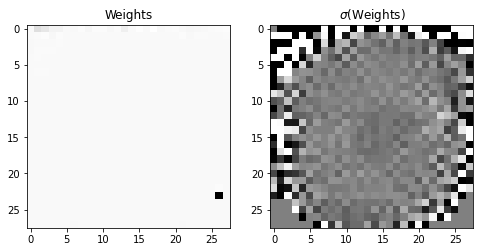

Intercept: 1.4778
Lowest weight -20871.75 is at pixel 670
R^2: 0.8038


In [ ]:
digit = 0

x_data, y_data = getDataForDigit(digit)
reg = linearRegression(x_data, y_data)

print(f"Regression results for digit '{digit}'")
showAsImages([reg.coef_, tf.nn.sigmoid(reg.coef_)], ["Weights", "$\\sigma$(Weights)"])
print(f"Intercept: {reg.intercept_:.4f}")
print(f"Lowest weight {reg.coef_.min():.2f} is at pixel {reg.coef_.argmin()}")
print(f"R^2: {reg.score(x_data, y_data):.4f}")

Since a major goal is reducing compositionality, and since dealing with 784 input parameters is a little cumbersome, we need a way of elimitating some pixels entirely. One strategy is to prioritize pixels based on their variance in the dataset. For the MNIST images, most of the pixels along the edge of the image are black no matter which image we look at, so these pixels have a variance of zero and should not be included in our mathematical model.

Intuitively, if we are building a progressively more complex equation, we should add the pixels with the **highest variance first**. This could possibly be extended to **terms with high variance** instead of just input variables.

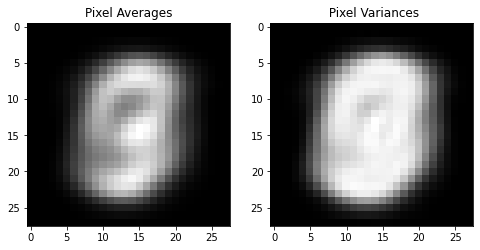

Max pixel variance is 0.2009 at pixel 378
Max pixel average is 0.5606 at pixel 435


In [ ]:
x_data, _ = getDataForDigit(0)

pixel_averages = np.average(x_data, axis=0)
pixel_variances = np.var(x_data, axis=0)

showAsImages([pixel_averages, pixel_variances], ["Pixel Averages", " Pixel Variances"])

print(f"Max pixel variance is {pixel_variances.max():.4f} at pixel {pixel_variances.argmax()}")
print(f"Max pixel average is {pixel_averages.max():.4f} at pixel {pixel_averages.argmax()}")

The graph below shows how the accuracy of the equation increases as more pixels are included in the linear model. Pixels with higher variance in the input space are added before low-variance pixels. The graph confirms our expectations that the marginal benefit of adding a single pixel decreases as the number of pixels already in the equation increases.

Show how linear model gets better as more pixels are added.
Pixels with highest variance are added first.


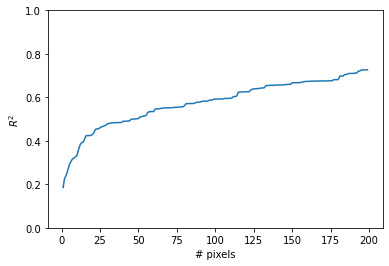

In [ ]:
x_data, y_data = getDataForDigit(0)

pixel_variances = sorted(enumerate(np.average(x_data, axis=0)), key=lambda pair: pair[1], reverse=True)

r2vals = []
for numpixtoinclude in range(1, 200):
  includeinreg = [x_data[:,pair[0]] for pair in pixel_variances[:numpixtoinclude]]
  X = np.column_stack(includeinreg)
  reg = linearRegression(X, y_data)
  r2vals.append(reg.score(X, y_data))

print("Show how linear model gets better as more pixels are added.")
print("Pixels with highest variance are added first.")
axis = plt.figure().add_subplot(111)
axis.set_ylim([0, 1])
axis.plot(range(1, 200), r2vals)
axis.set_xlabel("# pixels")
axis.set_ylabel("$R^2$")
plt.show()


## Introducing Quadratic Terms

Here, we will start to construct some Python infrastructure for dealing with data and mathematical equations together. We will introduce a `pruneByVariance` function on equations which removes terms with low variance in the input space. The output of the following code first shows the best fit linear equation of the top ten high-variance terms and its accuracy (0.45). The equation is then augmented with the quadratic terms built from those ten inputs and prunned back down to ten terms. Four of the original linear terms were replaced with quadratic terms which increased the accuracy to 0.51.

In [10]:
class Term:
  def __init__(self, name, data):
    self._name = name
    self._data = data
    self._coef = None
    self._var = None
  def __lt__(self, other):
    return self._coef < other._coef
  def __eq__(self, other):
    return self._coef == other._coef
  def __repr__(self):
    if self._coef == None:
      return f"\\_{self._name}"
    return f"{self._coef:.2f}{self._name}"
  def __mul__(self, other):
    return Term(self._name+other._name, self._data*other._data)
  def getVariance(self):
    if self._var != None: return self._var
    self._var = np.var(self._data)
    return self._var
  def getCoefMag(self):
    return np.abs(self._coef)

class Equation:
  def __init__(self, terms=None):
    self._terms = []
    self.rsquared_ = None
    self.intercept_ = None
  def fitTerms(self, y_data):
    X = np.column_stack([t._data for t in self._terms])
    reg = sklearn.linear_model.LinearRegression()
    reg.fit(X, y_data)
    for i, c in enumerate(reg.coef_):
      self._terms[i]._coef = c
    self.rsquared_ = reg.score(X, y_data)
    self.intercept_ = reg.intercept_
  def pruneByVariance(self, remaining):
    self._terms = sorted(eq._terms, key=Term.getVariance, reverse=True)[:remaining]
  def pruneByCoef(self, remaining):
    self._terms = sorted(eq._terms, key=Term.getCoefMag, reverse=True)[:remaining]
  def pruneByVarTimesCoef(self, remaining):
    keyFunc = lambda t: t.getCoefMag()*t.getVariance()
    self._terms = sorted(eq._terms, key=keyFunc, reverse=True)[:remaining]
  def display(self):
    print("$"+" + ".join([t.__repr__() for t in self._terms])+"$")
    #display(Latex("$"+" + ".join([t.__repr__() for t in self._terms])+"$"))

x_data, y_data = getDataForDigit(0)

# Get top linear terms
eq = Equation()
for i, singlepixeldata in enumerate(x_data.T):
  eq._terms.append(Term("x_{%d}" % i, singlepixeldata))
eq.fitTerms(y_data)
eq.pruneByVariance(10)
eq.fitTerms(y_data)
eq.display()
print(eq.rsquared_)
#eq.pruneByVariance(5)

# Add quadratic terms (build from the linear terms)
quadTerms = []
for i, t1 in enumerate(eq._terms):
  for t2 in eq._terms[i:]:
    quadTerms.append(t1*t2)
eq._terms += quadTerms

eq.fitTerms(y_data)
eq.pruneByCoef(10)
eq.fitTerms(y_data)
eq.display()
print(eq.rsquared_)

$-3.07x_{378} + -0.44x_{406} + 1.05x_{627} + -0.07x_{437} + -2.46x_{409} + -0.48x_{461} + -0.58x_{433} + -1.93x_{462} + 0.50x_{628} + -1.23x_{464}$
0.44579526260682245
$-10.66x_{378} + -3.53x_{409} + -3.54x_{462} + -4.21x_{461} + 6.96x_{378}x_{378} + 4.27x_{406}x_{409} + 2.47x_{627} + 4.60x_{461}x_{462} + -1.85x_{406}x_{437} + -2.35x_{627}x_{409}$
0.5052866163968938


---

# Maclaurin Series Approximations

## Linear Functions

The first step toward approximating polynomials is approximating linear functions. At first glance, this may seem unnecessary since a neural network's feedforward mechanism is primarily linear to begin with. However, the non-linear activation function is precisely the reason this section is still important. Here, I detail how a neural network can model a linear function even when non-linear functions are used in the computation.

The network we will build has one input node, one output node, and one hidden node. Consider any activation function $a(x)$ with a non-zero derivative at $x=0$. No matter the function $a$, Taylor's Theorem allows us to rewrite (a portion of) $a$ as an infinite polynomial.

$$ a(x) = \sum_{n = 0}^{\infty} \frac{a^{(n)}(0)}{n!} x^n \qquad \text{(Taylor's Theorem)} $$

First, replace $x$ with $hx$ where $h$ is positive. We will eventually consider what happens when $h$ approaches zero.

$$ a(hx) = \sum_{n = 0}^{\infty} \frac{a^{(n)}(0)}{n!} (hx)^n $$

Now rewrite this equation by isolating the linear term on the left.

$$ ha'(0) x = a(hx) - a(0) - \sum_{n=2}^{\infty} \frac{h^n a^{(n)}(0)}{n!} x^n $$

Isolate $x$ on the left.

$$ x = \frac{a(hx)}{ha'(0)} - \frac{a(0)}{ha'(0)} - \sum_{n=2}^{\infty} \frac{h^{n-1} a^{(n)}(0)}{a'(0)n!} x^n $$

If we consider the limit as $h \rightarrow 0$, the summation drops out because $h^{n-1}$ will vanish for any $n \ge 2$. We are left with:

$$ x = \lim_{h \rightarrow 0} \frac{a(hx) - a(0)}{h a'(0)} $$

Let's introduce some constants so we can rewrite the equation to see the correspondence with a neural network.

$$ x = \lim_{h \rightarrow 0} \left( W_1 a(W_0 x + B_0) + B_1 \right) $$

| - layer - | - - - - weight - - - - | - - - - - - bias - - - - - - |
| --------: | :-----------------: | :--------------: |
| first  | $W_0=h$                | $B_0 = 0$        |
| second | $W_1=\frac{1}{ha'(0)}$ | $B_1 = -W_1 a(0)$ |

This equation and table shows that we can approximate the identity function with arbitrary accuracy using just one hidden node (i.e. one application of the non-linear function $a$). An arbitrary linear function can be approximated by adjusting the second-layer weight and bias.



## Approximating $x^2$

The same general process to approximating linear functions can be applied to approximating quadratic polynomials as well. As before, start with Taylor's Theorem and isolate the desired degree of $x$ on the left (in this case $x^2$).

$$ x^2 = \frac{2a(hx)}{h^2 a^{(2)}(0)} - \frac{2a(0)}{h^2 a^{(2)}(0)} - \frac{2a'(0)x}{h a^{(2)}(0)} - \frac{2}{h^2 a^{(2)}(0)}\sum_{n=3}^{\infty} \frac{h^n a^{(n)}(0)}{n!} x^n $$

If we consider the limit as $h \rightarrow 0$, the sum term drops out because $h^n / h^2$ will always approach zero for any $n \ge 3$. We are left with the following:

$$ x^2 = \lim_{h \rightarrow 0} \left( \frac{2}{h^2 a^{(2)}(0)}a(hx) - \frac{2a(0)}{h^2 a^{(2)}(0)} - \frac{2a'(0)}{h a^{(2)}(0)}x \right) $$

Notice that this formula has an $x$ (all the way to the right) that does not go through an activation function. We can subsitute this $x$ for the linear approximation in the section above. Notably, the expression will now be a multivariate limit, so rename the two limit variables $h_2$ and $h_1$ where $h_1$ is the variable from the linear (degree 1) approximation. Interestingly, this limit does not exist (it evaluates differently depending on how $(h_1, h_2)$ approaches $(0,0)$). However, if $h_1 = h_2^2$, then we get the result we want:

$$ x^2 = \lim_{h \rightarrow 0} \frac{2}{h^2 a^{(2)}(0)} \left( a(hx) - \frac{a(h^2 x)}{h} - \frac{(h-1)a(0)}{h} \right) $$



## Approximating $x^2$ (Second approach)

This approach is a little cleaner than the above approach, we still start with Taylor series, but we use the fact that even powers of $x$ are even functions.

$$ a(hx) = \sum_{n = 0}^{\infty} \frac{a^{(n)}(0)}{n!} (hx)^n \qquad \text{(Taylor's Theorem)} $$

$$ a(-hx) = \sum_{n = 0}^{\infty} \frac{a^{(n)}(0)}{n!} (-hx)^n \qquad \text{(Taylor's Theorem)} $$

If we add these two equations together, we can get every odd term to drop out.

$$ a(hx) + a(-hx) = \sum_{n = 0}^{\infty} \left( \frac{h^n a^{(n)}(0)}{n!} x^n + \frac{(-1)^n h^n a^{(n)}(0)}{n!} x^n \right) $$

$$ a(hx) + a(-hx) = \sum_{n = 0}^{\infty} \frac{2 h^{2n} a^{(2n)}(0)}{(2n)!} x^{2n} $$

Now separate out the first two terms of the sum.

$$ a(hx) + a(-hx) = 2 a(0) + h^2 a^{(2)}(0) x^2 + \sum_{n = 2}^{\infty} \frac{2 h^{2n} a^{(2n)}(0)}{(2n)!} x^{2n} $$

Isolate $x^2$

$$ x^2 = \frac{a(hx)}{h^2 a^{(2)}(0)} + \frac{a(-hx)}{h^2 a^{(2)}(0)} - \frac{2 a(0)}{h^2 a^{(2)}(0)} - \frac{1}{a^{(2)}(0)} \sum_{n = 2}^{\infty} \frac{2 h^{2n-2} a^{(2n)}(0)}{(2n)!} x^{2n} $$

Consider the limit as $h \rightarrow 0$. The sum term drops out. Factor out common terms, and we are left with:

$$ x^2 = \lim_{h \rightarrow 0} \frac{a(hx) + a(-hx) - 2a(0)}{h^2 a^{(2)}(0)} $$

This expression converges much faster than the previous method.

## Approximating $x^d$

The process for approximating $x^2$ can be repeated, this time for a general degree $d$. This time, we require that $a^{(d)}(0) \neq 0$. From Taylor's Theorem, isolate the desired power on the left. The $n$ in the sum iterates from zero to infinity, but skips $d$.

$$ x^d = \frac{d!a(hx)}{h^d a^{(d)}(0)} - \frac{d!}{h^d a^{(d)}(0)}\sum_{n\neq d} \frac{h^n a^{(n)}(0)}{n!} x^n $$

Once again, consider the limit as $h \rightarrow 0$. All of the terms in the sum where $n > d$ are going to approach zero leaving us with a finite sum.

$$ x^d = \lim_{h \rightarrow 0} \left( \frac{d!}{h^d a^{(d)}(0)} a(hx) - \sum_{n = 0}^{d - 1} \frac{d! h^{n-d} a^{(n)}(0)}{n! a^{(d)}(0)} x^n \right) $$

Introduce constants:

$$ x^d = \lim_{h \rightarrow 0} \left( A a(hx) - \sum_{n = 0}^{d - 1} B_n x^n \right) $$

$$ A = \frac{d!}{h^d a^{(d)}(0)} \qquad B_n = A h^n a^{(n)}(0) $$

Written a different way:

$$ x^d = \lim_{h \rightarrow 0} \left( A a(hx) - \sum_{n = 0}^{d - 1} B_n (hx)^n \right) $$

$$ A = \frac{d!}{h^d a^{(d)}(0)} \qquad B_n = A a^{(n)}(0) $$

---

# Change-of-Basis Approximation Strategy

This section describes a general strategy for approximating any function $f: \mathbb{R} \rightarrow \mathbb{R}$ with a neural network using an arbitrary activation function $a$ (with certain restrictions) to any desired accuracy using a single hidden activation layer. The basic idea is to find a representation of $f$ as a linear combination of various functions of the form $a(hx + k)$. For a more concrete example, see [Using Maclaurin Approximation](#scrollTo=iZycguIdbhuG).

Start with:
* $f: \mathbb{R} \rightarrow \mathbb{R}$ the function to be approximated
* $a: \mathbb{R} \rightarrow \mathbb{R}$ an activation function
* A function basis $\mathcal{F}$, for example:
  * polynomials $\{1, x, x^2, ...\}$
  * sinusoids $\{1, \sin(x), \cos(x), \sin(2x), \dots\}$
* A methodology for producing an approximation $f_{app}$ of $f$ using finite subsets of the basis $\mathcal{F}$
  * Maclaurin series (requiring $f_{app}^{(n)}(0) = f^{(n)}(0)$ for some values $n \ge 0$)
  * Point Sampling (requiring $f_{app}(n) = f(n)$ for some values $n$)
  * Matching Integrals (requring $\int_R f^{(n)}_{app}(x)\ dx = \int_R f^{(n)}(x)\ dx$ for some values $n \ge 0$)
  * Remez Algorithm
  * Fourier series

General process:
1. Find an approximation $f_{app}$ of $f$ that is a linear combination of $d$ vectors in $\mathcal{F}$.
2. Construct a set of independent functions $\mathcal{A} = \{a(h_0 x + k_0), a(h_1 x + k_1), \dots, a(h_d x + k_d) \}$
3. Construct a basis $\mathcal{B}$ of approximations of the functions in $\mathcal{A}$ where $\mathcal{B}_i \approx \mathcal{A}_i$
4. Construct a change of basis matrix $B = \begin{bmatrix} \mathcal{B}_0 & \mathcal{B}_1 & \cdots & \mathcal{B}_d \end{bmatrix}$ that converts from $\mathcal{B}$-coordinates to $\mathcal{F}$-coordinates.
5. Find the coordinates of $f_{app}$ in $\mathcal{B}$ by inverting the change of basis matrix: $\text{coords}_{\mathcal{B}}(f_{app}) = B^{-1}\ \text{coords}_{\mathcal{F}}(f_{app})$

The numbers in $\text{coords}_{\mathcal{B}}(f_{app})$ are the weights coming out of the neurons in the hidden layer of the network. The weights and biases fed _into_ the hidden layer neurons are the $h,k$ values from step 2.

There are two approximations happening: the approximation of $f$ and the approximation of $a$. Both approximations are represented in the same finite-dimensional subspace of $\mathcal{F}$, meaning the transformation from one to the other is a finite linear operator.



## Using Maclaurin Approximation

Here is an example of applying the above approximation strategy using Maclaurin series approximation and the standard basis for $d$-degree polynomials for $\mathcal{F}$.

To start, we will use $\mathcal{A} = \{a(0), a(hx), a(2hx), \dots, a(dhx)\}$

The approximations $\mathcal{B}$ will be found using the first $d$ terms of the Maclaurin expansion.

$$ \mathcal{A}_j = a(khx) \approx \sum_{n=0}^{d} \frac{j^n h^n a^{(n)}(0)}{n!} x^n = \mathcal{B}_j $$

Now construct the change of basis matrix $B$. The columns of $B$ are the vectors in $\mathcal{B}$ written with respect to the standard polynomial basis $\{1, x, x^2, \dots, x^d\}$. Note that $a^{(i)}(0) \ne 0$ for $0 \le i \le d$ otherwise the matrix will not be invertible.

$$ B = \begin{bmatrix} \mathcal{B}_0 & \mathcal{B}_1 & \cdots & \mathcal{B}_d \end{bmatrix} $$

$$ B_{i,j} = \frac{j^i h^i a^{(i)}(0)}{i!} $$

Multiplying by $B$ on the left will convert coordinates with respect to $\mathcal{B}$ into standard basis coordinates. Both coorinate vectors are column vectors. $p$ is the $d$-degree polynomial approximation of $f$.

$$ B\ \text{coords}_{\mathcal{B}}(p) = \text{coords}(p) $$

To get the new coordinates with respect to $\mathcal{B}$, simply multiply the standard coordinates by the inverse of $B$.

$$ \text{coords}_{\mathcal{B}}(p) = B^{-1} \text{coords}(p) $$

Our neural network function that approximates $p$ is

$$ p(x) = \lim_{h \rightarrow 0} \left( \text{coords}_{\mathcal{B}}(p) \cdot a(\begin{bmatrix} 0 & hx & 2hx & \cdots & dhx \end{bmatrix}^t) \right) $$

In [ ]:
# returns an approximation for poly
# poly is a list [b0, b1, b2, ...] representing b0 + b1x + b2x^2 + b3x^3 + ...
# a_derivs is the list [a(0), a'(0), a''(0), ...]
# h should be close to zero (0.1 usually works well)
# returns the coefficients [c0, c1, c2, ...] such that
# c0 a(0) + c1 a(hx) + c2 a(2hx) + ... approximates poly
def getApprox(poly, a_derivs, h):
  degree = len(poly) - 1
  # construct B matrix
  # Note, the B matrix in the math above is actually matmul(C, B) where C
  # is a diagonal matrix of "row coefficients"
  B = []
  for row in range(degree + 1):
    B.append([])
    for col in range(degree + 1):
      B[row].append(math.pow(col, row))
  B = np.array(B)

  C_inv = []
  for row in range(degree + 1):
    C_inv.append([])
    coefficient = math.factorial(row) / (math.pow(h, row) * a_derivs[row])
    for col in range(degree + 1):
      C_inv[row].append(coefficient if row == col else 0.0)
  C_inv = np.array(C_inv)

  # construct coords vector
  coords = np.array(poly).reshape((degree+1, 1))

  return np.matmul(np.matmul(np.linalg.inv(B), C_inv), coords)

# derivatives of 1/(1+exp(-(x-1)))
#a_derivs = [0.26894142137, 0.196611933241, 0.0908577476729, -0.0353255805162, -0.123506861366, -0.0510419761245]

# derivatives of 1/(1+exp(-(5x - 1)))
a_derivs = [0.26894142137, 0.983059666207, 2.27144369182, -4.41569756453, -77.191788354, -159.506175389]

# approximate x - (1/6)x^3, a Maclaurin approx for sin(x).
#getApprox([0.0, 1.0, 0.0, -1.0/6.0], [0.26894142137, 0.196611933241, 0.0908577476729, -0.0353255805162], 0.5)

# approximates 0.5 sin(pi x) + 0.5
# via its degree-5 maclaurin expansion
getApprox([0.5, 1.57079632679, 0.0, -2.58385639002, 0.0, 1.27508201994],
          a_derivs, 0.5)

array([[ -25.07715296],
       [  97.79126971],
       [-151.51657341],
       [ 122.7842585 ],
       [ -50.69813563],
       [   8.5754747 ]])

In [ ]:
# len(inputs) = len(outputs) = d + 1
# returns the unique d-degree polynomial p that
# satisfies p(inputs[i]) = outputs[i] for each i.
def getPolyApprox(inputs, outputs):
  degree = len(inputs) - 1
  M = []
  for row in range(degree + 1):
    M.append([])
    for col in range(degree + 1):
      M[row].append(math.pow(inputs[row], col))
  M = np.array(M)

  outputs = np.array(outputs).reshape((degree+1, 1))
  return np.matmul(np.linalg.inv(M), outputs)

def pointSampledApprox(a, p):
  degree = len(p) - 1
  basis = []
  for i in range(degree+1):
    c = i / (degree+1)
    a_shifted = lambda x: a(5.0 * (x - c))
    inputs = [x / degree for x in range(degree+1)]
    outputs = [a_shifted(x) for x in inputs]
    basis.append(getPolyApprox(inputs, outputs))

  B = np.column_stack(basis)
  print(np.matmul(np.linalg.inv(B), np.array(p).reshape((degree+1, 1))))


In [ ]:
p = getPolyApprox([0.0, 0.25, 0.5, 0.75, 1.0], [0.5, 1.0, 0.5, 0.0, 0.5])
pointSampledApprox(lambda x: 1.0 / (1.0 + math.exp(-x)), p)

[[-2.47988103]
 [10.84523535]
 [-9.37800578]
 [-3.47771911]
 [ 5.89490843]]


---

# Approximating an Arbitrary Function using Convolution

This section describes a neural network configuration that can approximate a real-valued function $\mathbb{R} \rightarrow \mathbb{R}$ on a certain domain. The structure is inspired by signal convolution in linear systems, but it is also reminiscent of a fuzzy logic system. [Implementation](#scrollTo=x5qhSvWBw4bI) provides code for exploration and testing.


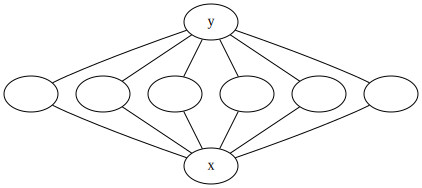

In [ ]:
g = gv.Graph()
g.node_attr["label"] = ""
g.node("i", "x")
g.node("o", "y")
g.edges(["oa", "ob", "oc", "od", "oe", "of"])
g.edges(["ai", "bi", "ci", "di", "ei", "fi"])
g

The network has one input node, one output node, and one hidden layer. Let $h$ denote the number of nodes in the hidden layer. The approximation becomes better as $h$ increases.

Broadly, this network approximates a function by partitioning the domain of interest into $h$ equally-sized segments. The goal for any input is to get one particular node in the hidden layer to activate while the rest are deactivated. The activated node should correspond to the segment in which the input resides. The final set of weights can then easily be tuned so that the final output corresponds to the activated node according to the function being approximated.

Intuitively, each hidden node "detects" when the input is close to a particular value. To accomplish this, an activation function $a$ should be used such that:

$$a(0) = 1$$
$$\lim_{x \rightarrow \infty} a(x) = \lim_{x \rightarrow -\infty} a(x) = 0$$

For example, a gaussian or "spike" curve will suffice. Now suppose the $i$-th hidden node needs to detect when the input is near $x_i$. Then the activation $v_i$ of that node should be:

$$ v_i = a(wx -wx_i) $$

The weight $w$ can be varied, but the bias needs to be set so that $v_i = 1$ when $x = x_i$.

If we are approximating a function $f$, then the output $y$ is given by:
$$ y = \sum_{i=1}^{h} v_i f(x_i) $$

The neural network is essentially just calculating $f$ by approximating the following equation:

$$ f(x) = \int_{a}^{b} f(\tau)\ \delta(x - \tau)\ d\tau \approx \sum_{i=1}^{h} f(i \Delta)\ r(x - i \Delta) $$

where $(a,b)$ is our domain of interest, $\Delta = (b - a)/h$, $r(0) = 1$, and $r(x) = 0$ for $x \ge h$ or $x \le -h$.

If we substitute the computation for $v_i$ into the equation for $y$, we can see the similarity:

$$ y = \sum_{i=1}^{h} f(x_i)\ a(wx - wx_i)$$

If we let $x_i = i\Delta$ and $a(wt) = r(t)$, then the correspondence becomes complete.

$$ y = \sum_{i=1}^{h} f(i\Delta)\ a(w \cdot (x - i\Delta))$$

## Implementation

Currently, the function being approximated is $0.5 \sin(\pi x)$. Change [this cell](#scrollTo=AKMcQ9OXEPdR) if you want to approximate a different function.

[This cell](#scrollTo=zXPo8b9yndcO) manually sets the weights and biases of the network to the values prescribed by the theory. These are not guarenteed to be the best values (training the network afterwards does give improvements), but gives a good starting point.

If the weights and biases are randomly initialized, the network probably won't learn on its own to use this approximation method. It just serves as a demonstration of how a network with one hidden layer could theoretically learn any real valued function.

In [ ]:
# Constructs a new model called "sinModel"
# MyModel(h) constructs the 3-layer network described above with h
# nodes in the hidden layer.
class MyModel(tf.keras.Model):
  def __init__(self, h, **kwargs):
    super().__init__(**kwargs)
    #self.a = lambda x: tf.exp(-x**2)   # the gaussian activation function
    self.a = lambda x: tf.maximum(1-tf.abs(x), 0)  # sawtooth activation
    self.w1 = tf.Variable(tf.random.uniform(shape=[1, h]))
    self.b1 = tf.Variable(tf.random.uniform(shape=[1, h]))
    self.w2 = tf.Variable(tf.random.uniform(shape=[h, 1]))
    self.b2 = tf.Variable(tf.random.uniform(shape=[1, 1]))
  def hl_act(self, i, x, **kwargs):
    w1 = tf.reshape(self.w1[0,i], [1, 1])
    b1 = tf.reshape(self.b1[0,i], [1, 1])
    return self.a(tf.matmul(x, w1) + b1)
  def __call__(self, x, **kwargs):
    hiddenlayer = self.a(tf.matmul(x, self.w1) + self.b1)
    return tf.matmul(hiddenlayer, self.w2) + self.b2

sinModel = MyModel(6)

In [ ]:
# The function we want to approximate.
# In this case, 0.5sin(pi*x)
def f(x):
  return 0.5 * tf.sin(math.pi * x)

In [ ]:
# Manually set the weights and biases to approximate f on
# the interval [0,1]. Six sample values are used.

parts = tf.constant([[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]])
w = 5.0

sinModel = MyModel(6)
sinModel.w1.assign(tf.constant([[w, w, w, w, w, w]]))
sinModel.b1.assign(parts * -w)
sinModel.w2.assign(f(tf.reshape(parts, (6, 1))))
sinModel.b2.assign(tf.zeros(shape=(1,1)))

<tf.Variable 'UnreadVariable' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>

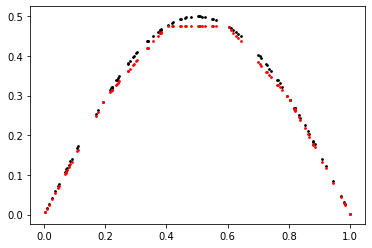

In [ ]:
# Test: plot the model approximation and the actual function f
x = tf.random.uniform((100, 1, 1), minval=0.0, maxval=1.0)
y = f(x)
y_obs = sinModel(x)
plt.scatter(x, y, c="black", s=3)
plt.scatter(x, y_obs, c="red", s=3)
plt.show()

In [ ]:
# Train the model
sinModel.compile(run_eagerly=False,
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                loss=tf.keras.losses.mean_squared_error)
sinModel.fit(x, y, epochs=1000, batch_size=100, verbose=0)

In [ ]:
# print weights and biases
print(sinModel.w1)

<tf.Variable 'Variable:0' shape=(1, 6) dtype=float32, numpy=
array([[5.       , 4.999203 , 4.9981747, 5.000848 , 5.0031466, 5.       ]],
      dtype=float32)>


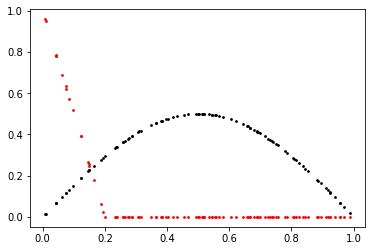

In [ ]:
# plot the activation of the 0-th hidden node
x = tf.random.uniform((100, 1, 1), minval=0.0, maxval=1.0)
y = f(x)
y_obs = sinModel.hl_act(0, x)

plt.scatter(x, y, c="black", s=3)
plt.scatter(x, y_obs, c="red", s=3)
plt.show()

## 4-layer version

Commonly used activation functions like sigmoid and the rectified linear don't usually tend toward zero on both ends. However, inserting another hidden layer allows us to use sigmoidal activation functions.

Broadly, the purpose of the nodes in the second hidden layer is the same as the hidden nodes in the 3-layer version: to activate when the input is close to some fixed value. The nodes in the first hidden layer should be zero, when read from left to right, until some node where the values switch to one.

Speaking of the hidden layers in terms of signals, the second hidden layer is the "derivative" of the first, and the feed-forward calculation between them can be compared to convolving the first signal with the $\delta$ signal.

---

# Helpful Mathematical Theory

## Linear Systems Background

Some vocabulary:

* **Def** A _signal_ (denoted with $x$ or $y$) just refers to a real-valued function (usually over time). Alternatively, it can be thought of as a list of (output) values.
* **Def** _Shifted signal_: $x \Rsh s$ is the signal such that $(x \Rsh s)(t) = x(t - s)$. Usually, $x(t - s)$ denotes the shifted signal itself, but using the denotation $\Rsh$ clarifies that shifting is an operation on a signal. 
* **Def** A _system_ or _transform_ (denoted $T$) is a "function on functions", a transformation from one signal to another.
* **Def** A _linear system_ is a system that satisfies homogeneity and additivity from linear algebra.
* **Def** A _shift-invariant system_ $T$ satisfies the property $T[x \Rsh s] = T[x] \Rsh s$ for any signal and shift amount.
* **Def** The _unit impulse_ signal (denoted $\delta(t)$) is a spike at time zero and is defined such that:
$$ \int_{-\infty}^{t} \delta(\tau)\ d\tau = \begin{cases} 0 \qquad t < 0 \\ 1 \qquad t > 0 \end{cases}$$

Any signal can be represented as a linear combination of shifted and scaled impulse signals:
$$ x(t) = \int_{-\infty}^{\infty} x(\tau)\ \delta(t - \tau)\ d\tau $$

Suppose $T$ is a linear shift-invariant transform. Then, by properties of linearity and shift-invariance:
$$ T[x(t)] = \int_{-\infty}^{\infty} x(\tau)\ (T[\delta])(t - \tau) \ d\tau $$
This means that $T$ is completely characterized by how it maps the unit impulse signal. $T[\delta]$ is called the _impulse response signal_.

**Def** A _convolution_ is a combination of two signals. We say $x * y$ is the result of convolving $x$ with $y$.
  $$ (x * y)(t) = \int_{-\infty}^{\infty} x(\tau)\ y(t - \tau)\ d\tau $$
  $$ x * y = \int_{-\infty}^{\infty} x(\tau)\ (y \Rsh \tau)\ d\tau $$
  Think of convolution as constructing a new signal that is a linear combination of a set of base signals. But each base signal is just a shifted version of a single signal $y$. The factors that scale the base signals are the outputs of $x$.

Special Convolutions:
 * $x * \delta = x$
 * $x * 1 = \int_{-\infty}^{\infty} x(\tau)\ d\tau$
 * $x * \text{step} = \int_{-\infty}^{t}x(\tau)\ d\tau \qquad$ ("step" is the integral of $\delta$)



Differentiation on real functions is a shift-invariant linear operation, so it can be expressed as a convolution ($d$ is the "derivative" of $\delta$):
$$ \frac{dx}{dt} = x * d = \int_{-\infty}^{\infty} x(\tau)\ (d \Rsh \tau)\ d\tau $$

A Taylor series is similar to a convolution, but uses a discrete sum instead of the continuous integral.

$$ f(x) = \sum_{n=0}^{\infty} \frac{f^{(n)}(a)}{n!} (x - a)^n \qquad \forall x, a \in \mathbb{R} $$

$$ f(x) = \sum_{n=0}^\infty \frac{f^{(n)}(0)}{n!} x^n $$

## Neural Net vs. Fuzzy Inference System

The feedforward calculation of a neural network is a (linear) affine transformation composed with a nonlinear function $\sigma$.

$$ x^{(l+1)} = \sigma(W^{(l)} x^{(l)} + b^{(l)}) \qquad \text{whole layer}$$

$$ x^{(l+1)}_i = \sigma\left( \sum_j W_{i,j}^{(l)} x_j^{(l)} + b_i^{(l)} \right) \qquad \text{single node} $$

_Index confusion_:
* _Superscripts in parentheses_ always refer to the layer.
* _Subscripts_ index the elements within a particular layer. Vectors only have one subscript. Matrices have two comma-separated subscripts for the _row_ and _col_ respectively. Letting the _col_ vary looks like moving left-right across the matrix.
* Matrix vector multiplication example: $\sum_j W_{i,j}x_j = (Wx)_i$

### Piecewise-linear neural network

If the activation function $\sigma$ is piecewise-linear, such as a rectified linear or absolute value, then the entire feed-forward network will be piecewise-linear because composing two piecewise-linear functions yields another piecewise-linear function.

**Theorem** The composition of two piecewise-affine functions is itself piecewise-affine.

**Proof** Let $f$ and $g$ be piecewise-affine. Since $f$ is piecewise, the domain of $f$ can be divided into regions $\{r_1, r_2, ...\}$ such that $f$ is purely affine on any one region $r_i$. The same can be said for $g$ on regions $\{s_1, s_2, ...\}$. Now the composition of two purely affine functions is itself affine. This means that $(g \circ f)$ is affine on any region $r_i \cap \{x | f(x) \in s_j\}$ since this region is a subset of $r_i$, and its mapping via $f$ is a subset of $s_j$. So $(g \circ f)$ is piecewise-affine.

### Fuzzy Inference System

The function defined by a fuzzy inference system $f: \mathbb{R}^n \rightarrow \mathbb{R}^m$ is piecewise-polynomial of degree $n$. This is because for each region in the domain, $f$ is defined as a linear combination of $2^n$ membership functions. As an example, for a one-input one-output system, on the domain $[0,1]$, these membership functions are $(1 - x)$ and $x$.

$$ f(x) = c_0(1 - x) + c_1x $$

If the input becomes 2-dimensional, then $f$ on the unit square becomes:

$$ f(x,y) = c_{00}(1-x)(1-y) + c_{01}(1-x)y + c_{10}x(1-y) + c_{11}xy $$

Each additional variable requires an additional multiplication in the definition of the membership functions.

## Universal Approximation Theorem

The universal approximation theorem says that neural networks with either arbitrary width or depth can approximate any continuous function to arbitrary accuracy.

* **Arbitrary Width** Given a non-polynomial activation function $\sigma: \mathbb{R} \rightarrow \mathbb{R}$ and input,output dimensions $d,D \in \mathbb{Z}^+$
 * for every continuous function $f: \mathbb{R}^d \rightarrow \mathbb{R}^D$,
 * for every compact subset $K$ of $\mathbb{R}^d$,
 * for every $\epsilon > 0$,
 * there exists linear affine maps $W_1, W_2$ such that
 * $\sup| f(x) - (W_2 \circ \sigma \circ W_1)(x) | < \epsilon$
* **Arbitrary Depth**
 * for every function $f: \mathbb{R}^n \rightarrow \mathbb{R}^m$,
 * for every $\epsilon > 0$,
 * there exists a fully-connected ReLU network $F$ with width $d_m = \max\{n+1,m\}$ such that,
 * $\int_{\mathbb{R}^n} | f(x) - F(x) |^p dx < \epsilon$

## Fourier Series

Fourier's Theorem states that any periodic function $f$ with period $L$ can be written as a sum of sines and cosines:

$$ f(x) = a_0 + \sum_{n=1}^{\infty} \left[ a_n\cos\left(\frac{2\pi nx}{L}\right) + b_n\sin\left(\frac{2\pi nx}{L}\right) \right] \qquad \text{(Fourier's Theorem)} $$

where the coefficients can be calculated as follows:

$$ a_n = \frac{2}{L}\int_0^{L} f(x)\cos\left( \frac{2\pi nx}{L} \right)\ dx $$
$$ b_n = \frac{2}{L}\int_0^{L} f(x)\sin\left( \frac{2\pi nx}{L} \right)\ dx $$

There is an equivalent exponential form that also generalizes to complex functions:

$$ f(x) = \sum_{n=-\infty}^{\infty} C_n e^{i\, 2\pi nx/L} \qquad \text{(Fourier's Theorem)} $$

$$ C_n = \frac{1}{L}\int_0^L f(x) e^{i\, 2\pi nx/L}\ dx $$

## Fourier Approximations

Fourier approximations work because the set of functions $\{\frac{1}{\pi}\sin nx | n \ge 1\} \cup \{\frac{1}{\pi} \cos nx | n \ge 1\} \cup \{\frac{1}{2\pi}\}$ forms an orthonormal basis of the set of real-valued functions with period $2\pi$. This is because:

* All functions in this set have unit length (e.g. $\int_0^{2\pi} \sin^2 (nx)\ dx = 1$)
* All functions in this set are pairwise orthogonal (e.g. $\int_0^{2\pi} \sin(nx)\cos(mx)\ dx = 0$)
* There are "enough" of them to span the entire vector space

Finding the Fourier approximation of a function $f$ just requires calculating the coorinates of $f$ in this new basis. Recall the projection formula:

$$ \text{proj}_{\vec{w}} \vec{v} = \frac{\vec{v} \cdot \vec{w}}{||\vec{w}||^2} \vec{w} $$

So we just need to project our function $f$ onto each basis vector. For example,

$$ \text{proj}_{\sin(x)/\pi} f = \frac{1}{\pi^2} \left( \int_0^{2\pi} f(x) \sin(x)\ dx \right) \sin(x) $$

Similar approximations can be done with any set of orthogonal functions such as [orthogonal polynomials](https://en.wikipedia.org/wiki/Orthogonal_polynomials).

The discrete Fourier Transform transforms a sequence of complex numbers $ x_0, x_2, \dots, x_{N-1} $ into another sequence:

$$ X = F\pmb{x} $$

$$ \begin{bmatrix} X_0 \\ X_1 \\ \vdots \end{bmatrix} = \begin{bmatrix} \omega^{0 \cdot 0} & \omega^{0 \cdot 1} & \\ \omega^{1 \cdot 0} & \omega^{1 \cdot 1} & \cdots \\ & \vdots & \end{bmatrix} \begin{bmatrix} x_0 \\ x_1 \\ \vdots \end{bmatrix} $$

$$ \omega = e^{-\frac{2 \pi i}{N}} $$



## Spline Theory

Notes from "A Spline Theory of Deep Networks" by Balestriero and Baraniuk.

* **Def** A function $f: \mathbb{R^n} \rightarrow \mathbb{R}$ is _convex_ if the line segment connecting any two points on the graph lies entirely above the graph (think positive concavity or positive second derivative).
* **Def** An _affine spline_ is a continuous piecewise-affine function ($\mathbb{R^n} \rightarrow \mathbb{R}$).
* **Def** A _max-affine spline_ is defined as the maximum of a set of affine functions over the entire domain. Max-affine splines are necessarily globally convex and continuous no matter the choices of affine functions.
* **Def** An _adaptive-partitioning spline_ (such as a max-affine spline) is a spline were the domain partitioning is not a direct parameter, but instead determined by other parameters, and where the domain partitioning automatically changes as the direct parameters change.
* **Def** An _affine spline operator_ is obtained by simply concatenating affine splines to produce a function with multivariate output.
* **Def** A _max-affine spline operator_ (MASO) is an affine spline operator produced by concatenating max-affine splines.

Main result: most deep networks can be written as a composition of MASOs, one for each layer, even though a MASO can only approximate a convex function.

## Linear Regression with Vectors

Suppose we have $n$ datapoints $(x_i, y_i)$ where $x_i, y_i \in \mathbb{R}$. A linear regression problem attempts to find a function $f(x) = mx + b$ such that some sort of error function, like square differences, are minimized. This problem can reframed as finding values of $m,b$ such that the approximation below is "closest"

$$ \pmb{y} \approx X \pmb{ w } $$
$$ \begin{bmatrix} y_0 \\ y_1 \\ \vdots \end{bmatrix} \approx \begin{bmatrix} x_0 & 1 \\ x_1 & 1 \\ \vdots & \vdots \end{bmatrix} \begin{bmatrix} m \\ b \end{bmatrix} $$

Here is another interpretation of the above equation: Given each $x_i$, the vector $\pmb{y}$ is a representation of a function (think of "coordinates"). It represents a function by simply listing outputs associated with the given inputs. This vector sits in some vector space $V$. The columns of the $X$ matrix are also vectors in $V$ (representations of $x \mapsto x$ and $x \mapsto 1$).

But $\pmb{w}$ is a different representation of a function in a different, lower-dimensional vector space $W$. The matrix $X$ maps vectors from $W$ into $V$. The problem now becomes: "find the vector $\pmb{w}$ such that the distance from $\pmb{y}$ to $X\pmb{w}$ is minimum":

$$ \pmb{w} = \min_{w} || Xw - \pmb{y} ||^2 $$

There are two ways of finding $\pmb{w}$. The more traditional way is to use calculus. The partial derivatives are taken with respect to $m$ and $b$. Note that this is just another way to say that the sum of the square differences must be minimum.

$$ \nabla || X\pmb{w} - \pmb{y} ||^2 = \pmb{0} $$

Another way is to project the vector $\pmb{y}$ onto the space $X(W)$. The vectors $\pmb{w_i}$ can be any orthogonal basis of $W$.

$$ X(\pmb{w}) = \text{proj}_{X(W)}(\pmb{y}) = \sum_i \frac{\pmb{y} \cdot X(\pmb{w_i})}{|| X(\pmb{w_i}) ||^2} X(\pmb{w_i}) $$


Approximation: 0.40 + 0.60x + -1.41x^2


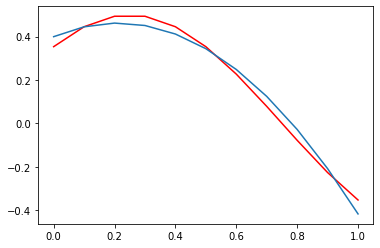

In [ ]:
# Example: quadratic regression using the projection method

# Generate data   yvec = 0.5sin(pi xvec + pi/4)
n = 11
xvec = np.linspace(0.0, 1.0, num=n)
yvec = 0.5 * np.sin(np.pi * xvec + np.pi * 0.25)
xsquarevec = xvec ** 2.0
onesvec = np.ones((n,))

# Construct the X matrix
X = np.column_stack((onesvec, xvec, xsquarevec))

# Calculate Xw by projecting onto the orthogonal basis "Xorth"
Xorth, _ = np.linalg.qr(X)
Xw = np.zeros((n, 1))
for c in range(3):
  col = Xorth[:,c:c+1]
  Xw = Xw + (np.matmul(yvec, col) / np.sum(col ** 2.0)) * col

# To get the original w vector, take any three coordinates from
# Xw and the corresponding rows from T. Then w = inv(X) Xw
Xsquare = np.resize(X, (3, 3))
w = np.matmul(np.linalg.inv(Xsquare), np.resize(Xw, (3,1)))
print("Approximation: {:.2f} + {:.2f}x + {:.2f}x^2".format(w[0,0], w[1,0], w[2,0]))

plt.plot(xvec, yvec, color="red")
plt.plot(xvec, [w[0,0] + w[1,0]*x + w[2,0]*x*x for x in list(xvec)])
plt.show()


## Dimensionality Reduction

* **Def** _Dimensionality reduction_ refers to some method of squeezing high dimensional data into a lower dimensional space in some meaningful way. These transformations can be linear or non-linear.
* **Def** _Feature selection_ is probably the simplest linear dimensionality reduction strategy. You simply eliminate one or more variables that are deemed unimportant.
* **Def** _Feature projection_ a generic linear dimensionality reduction strategy. Instead of naively eliminating one or more variables, you linearly-project the data into a smaller dimensional space. Think of rewriting the data in a different basis, then performing a feature selection.

* **Def** The _covariance_ of two random variables $X,Y$ is a measure of their correlation. A covariance near zero means they are independent. While univariable variance is $E(X - E(X))^2$, covariance is $E(X - E(X))(Y - E(Y))$.
* **Def** The _covariance matrix_ of $d$-dimensional data is a $d \times d$ matrix containing the covariances of each pair of dimensions.

The eigenvectors of the covariance matrix represent sort of the "principal components" of the distribution. If you were to rewrite the data using the eigenvector coordinates, the eigenvectors corresponding to the largest eigenvalues represent the directions in which the data is the most "spread out" or the most varied.

* **Def** _Principal Component Analysis_ is the primary version of feature projection where we keep the features in which the data is the most varied and eliminate features where the data does not vary as much. We can do this by rewriting the data in terms of a basis of eigenvectors of the covariance matrix and discard the "shortest eigenvectors" (smallest eigenvalues).

* **Dynamic Mode Decomposition** Another feature projection technique.


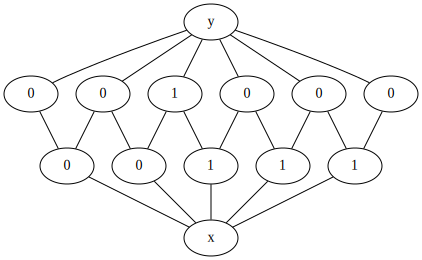

In [ ]:
g = gv.Graph()
g.node("i", "x")
g.node("o", "y")
for n in ["u", "v", "a", "b", "d", "e", "f"]: g.node(n, "0")
for n in ["w", "x", "y", "c"]: g.node(n, "1")
g.edges(["oa", "ob", "oc", "od", "oe", "of"])
g.edges(["au", "bu", "bv", "cv", "cw", "dw", "dx", "ex", "ey", "fy"])
g.edges(["ui", "vi", "wi", "xi", "yi"])
g

# Related Work

https://math.stackexchange.com/questions/3147754/why-do-deep-neural-networks-work-well

[Movement trajectory classification using supervised machine learning](http://kth.diva-portal.org/smash/get/diva2:1376904/FULLTEXT01.pdf)

### Cheng, Model Compression for DNNs survey

[Paper](https://arxiv.org/pdf/1710.09282.pdf)

* Parameter pruning and quantization
* Low-rank factorization
* Transferred/compact convolutional filters
* Knowledge distillation

### Safran, Depth-Width Tradeoffs in Approximating Natural Functions with Neural Networks

[Paper](https://arxiv.org/pdf/1610.09887.pdf)

* Large enough networks of depth 2 can approximate any  continuous target function on $[0, 1]^d$ to arbitrary accuracy.
* Deep network tend to outperform shallow networks of similar complexity.
* **Def** The $L_p$-norm of a vector $v$ is $||v||_p = \sqrt[p]{|v_0|^p + |v_1|^p + \cdots}$
* The the accuracy of expressing the indicator function of a Euclidean ball $\pmb{x} \mapsto \begin{cases} 1 & ||\pmb{x}||_2 \le 1 \\ 0 & \text{otherwise} \end{cases}$ on a two-layer network requires width exponential in $d$ (the dimension of the input space). Same is not true of a three-layer network.
* $L_1$ radial functions $\pmb{x} \mapsto f(||\pmb{x}||_1)$ where $f$ is piecewise-linear can be represented _exactly_ by a 3-layer ReLU network, but not by a 2-layer network.

### Neural Networks for Localized Approximation

[Paper](https://www.ams.org/journals/mcom/1994-63-208/S0025-5718-1994-1240656-2/S0025-5718-1994-1240656-2.pdf)

Question: Can neural networks satisfy a _local approximation_ property? i.e. that when the target function is modified only on a small subset of the Euclidean input space, only a few neurons need to be retrained.
Result: 2-layer heavyside-activated networks cannot have this property if the input space is more than one-dimensional. In contrast, 3-layer networks or higher are capable of having this property for any-dimensional input spaces.